<a href="https://colab.research.google.com/github/dalalelamine/AISD/blob/main/Skin_Cancer_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer MNIST: HAM10000 - Machine Learning Project
## CRISP-DM Methodology Implementation

**Team Members:**
- Dalal El Amine (Clustering & Image Data Understanding)
- Shelly Tyagi (Classification)
- Tianyi Gu (Outlier Detection & Business Understanding)

**Dataset:** Skin Cancer MNIST: HAM10000
- **Source:** https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
- **Description:** A large collection of multi-source dermatoscopic images of common pigmented skin lesions
- **Classes:** 7 different types of skin cancer lesions
- **Data Types:** Both tabular features and dermoscopic images


## CRISP-DM Phase 1: Environment Setup & Library Imports

**Purpose:** Import all required libraries and configure the environment for reproducible results.
**Expected Outcomes:** Properly configured environment with all dependencies loaded.

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import time
import os
from pathlib import Path
import glob
import os, shutil, subprocess, json
from pathlib import Path
from google.colab import files
from shutil import copy2

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Classification algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# Outlier detection algorithms
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical

# Image processing
from PIL import Image
import cv2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting parameters
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Environment setup completed successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Environment setup completed successfully!
TensorFlow version: 2.18.0
NumPy version: 2.0.2
Pandas version: 2.2.2


## CRISP-DM Phase 2: Business Understanding

**Assigned to:** Tianyi Gu
**Purpose:** Define business objectives, assess situation, determine data mining goals, and produce project plan.
**Expected Outcomes:** Clear understanding of project goals and success criteria.

### Business Objectives

**Primary Objective:** Develop an automated skin cancer detection and analysis system using the HAM10000 dataset to assist dermatologists in early diagnosis and treatment planning.

**Success Criteria:**
- Classification accuracy > 85% for skin cancer type identification
- Clustering analysis reveals meaningful patterns in lesion characteristics
- Outlier detection identifies rare or unusual cases requiring specialist attention

**Business Impact:**
- Early detection of skin cancer can significantly improve patient outcomes
- Automated screening can reduce healthcare costs and increase accessibility
- Pattern discovery can enhance medical understanding of skin lesions

### Situation Assessment

**Available Resources:**
- HAM10000 dataset with 10,015 dermatoscopic images
- Metadata including age, sex, localization, and diagnosis
- Team expertise in machine learning and image processing
- Computational resources for deep learning

**Constraints:**
- Limited time for model development and evaluation
- Class imbalance in the dataset
- Computational limitations for large-scale image processing
- Medical domain expertise requirements

**Assumptions:**
- Images are properly labeled and representative of real-world cases
- Feature extraction from images will provide meaningful insights
- Traditional ML methods can complement deep learning approaches

### Data Mining Goals

**Classification Goal:** Accurately classify skin lesions into 7 categories (MEL, NV, BCC, AK, BKL, DF, VASC) using both extracted features and raw images.

**Clustering Goal:** Discover hidden patterns and groupings in skin lesion characteristics that may reveal new insights about lesion types and patient demographics.

**Outlier Detection Goal:** Identify unusual or rare cases that deviate from normal patterns, potentially indicating misdiagnosed cases or rare lesion variants.

### Skin Cancer Types in HAM10000 Dataset

| Code | Full Name | Description |
|------|-----------|-------------|
| MEL | Melanoma | Most dangerous form of skin cancer |
| NV | Melanocytic nevus | Common mole, usually benign |
| BCC | Basal cell carcinoma | Most common skin cancer |
| AK | Actinic keratosis | Precancerous lesion |
| BKL | Benign keratosis | Non-cancerous skin growth |
| DF | Dermatofibroma | Benign skin tumor |
| VASC | Vascular lesion | Blood vessel-related lesion |

## CRISP-DM Phase 3: Data Loading & Initial Setup

**Purpose:** Load both feature dataset and image dataset, verify data integrity.
**Expected Outcomes:** Successfully loaded datasets with basic information displayed.

In [ ]:
# Define data paths - UPDATE THESE PATHS ACCORDING TO YOUR DATA LOCATION
# ╔════════════════════════════════════════════════════════════════╗
# ║  PHASE 3 – DATASET DOWNLOAD & BASIC STATS║
# ╚════════════════════════════════════════════════════════════════╝

# 1 ️Create data and images path
DATA_PATH = Path("/content/skin_cancer_data")
IMAGES_PATH      = DATA_PATH / "images"
METADATA_FILE    = DATA_PATH / "HAM10000_metadata.csv"

# 2 ️⃣  Skip download if everything is already here
if METADATA_FILE.exists() and len(list(IMAGES_PATH.glob("*.jpg"))) >= 10_000:
    print("✅ HAM10000 already present. Skipping download.")
else:
    IMAGES_PATH.mkdir(parents=True, exist_ok=True)

    # ── Kaggle credentials ────────────────────────────────────────
    if not Path("/root/.kaggle/kaggle.json").exists():
        print("⚠️  Kaggle API credentials missing.")
        print("👉  Upload your kaggle.json (Account ▸ Create New API Token).")
        files.upload()  # ← select kaggle.json in the dialog
        os.makedirs("/root/.kaggle", exist_ok=True)
        shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
        os.chmod("/root/.kaggle/kaggle.json", 0o600)
        print("✅ kaggle.json installed.")

    # ── Download & unzip HAM10000 ─────────────────────────────────
    print("⏬ Downloading HAM10000 …")
    subprocess.run(
        ["kaggle", "datasets", "download", "-d",
         "kmader/skin-cancer-mnist-ham10000",
         "-p", str(DATA_PATH), "--unzip"],
        check=True
    )

    # ── Move images into /images/  ────────────────────────────────
    seen, copied, duplicates = set(), 0, 0

    for jpg in DATA_PATH.rglob("*.jp*g"):

        # 🔒 Skip files that are already in ./images/
        if IMAGES_PATH in jpg.parents:
            continue

        dest = IMAGES_PATH / jpg.name
        if jpg.name in seen:
            duplicates += 1
            jpg.unlink(missing_ok=True)          # remove true duplicate
            continue

        copy2(jpg, dest)
        if dest.exists():
            copied += 1
            seen.add(jpg.name)
            jpg.unlink(missing_ok=True)          # delete original after copy
        else:
            print(f"⚠️  Failed to copy {jpg}")

    print(f"✅ Copied {copied:,} unique images to {IMAGES_PATH}")
    print(f"   Removed {duplicates:,} duplicate files")

    final_count = len(list(IMAGES_PATH.glob('*.jp*g')))
    print(f"📊 Images that actually exist on disk: {final_count:,}")


# 3 ️⃣  Make these paths visible to the *whole* notebook
globals().update({
    "DATA_PATH"   : str(DATA_PATH),
    "IMAGES_PATH" : str(IMAGES_PATH),
    "METADATA_FILE": METADATA_FILE.name
})

print("\n🌟  Ready!  Use these variables in later phases:")
print("   DATA_PATH    =", DATA_PATH)
print("   IMAGES_PATH  =", IMAGES_PATH)
print("   METADATA_FILE=", METADATA_FILE)

# Function to load and validate data
def load_ham10000_data(data_path, metadata_file, images_path):
    """
    Load HAM10000 dataset including metadata and verify image availability.

    Parameters:
    data_path (str): Path to main data directory
    metadata_file (str): Name of metadata CSV file
    images_path (str): Path to images directory

    Returns:
    pandas.DataFrame: Loaded metadata
    list: Available image files
    """
    try:
        # Load metadata
        metadata_path = os.path.join(data_path, metadata_file)
        print(f"Loading metadata from: {metadata_path}")

        if not os.path.exists(metadata_path):
            print(f"ERROR: Metadata file not found at {metadata_path}")
            print("Please ensure the HAM10000_metadata.csv file is in the correct location.")
            return None, None

        metadata = pd.read_csv(metadata_path)
        print(f"Metadata loaded successfully: {metadata.shape[0]} records, {metadata.shape[1]} columns")

        # Check for image files
        print(f"\nChecking for images in: {images_path}")

        if not os.path.exists(images_path):
            print(f"ERROR: Images directory not found at {images_path}")
            print("Please ensure the images are extracted to the correct location.")
            return metadata, []

        # Find all image files
        image_extensions = ['*.jpg', '*.jpeg', '*.png']
        image_files = []
        for ext in image_extensions:
            image_files.extend(glob.glob(os.path.join(images_path, ext)))

        print(f"Found {len(image_files)} image files")

        return metadata, image_files

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None

# Load the data
print("=== HAM10000 Data Loading ===")
metadata_df, image_files = load_ham10000_data(DATA_PATH, METADATA_FILE, IMAGES_PATH)

if metadata_df is not None:
    print("\n=== Dataset Overview ===")
    print(f"Total records in metadata: {len(metadata_df)}")
    print(f"Total image files found: {len(image_files)}")
    print(f"\nMetadata columns: {list(metadata_df.columns)}")
    print(f"\nFirst few records:")
    display(metadata_df.head())

    print(f"\nData types:")
    print(metadata_df.dtypes)

    print(f"\nMissing values:")
    print(metadata_df.isnull().sum())
else:
    print("\nDATA LOADING FAILED!")
    print("Please check the data paths and ensure the HAM10000 dataset is properly downloaded.")
    print("\nExpected file structure:")
    print("./data/")
    print("  ├── HAM10000_metadata.csv")
    print("  └── images/")
    print("      ├── ISIC_0024306.jpg")
    print("      ├── ISIC_0024307.jpg")
    print("      └── ...")

# Refresh file list so Phase 4–7 see the images
image_files = [str(p) for p in Path(IMAGES_PATH).glob("*.jp*g")]
print("Now found", len(image_files), "images")


⚠️  Kaggle API credentials missing.
👉  Upload your kaggle.json (Account ▸ Create New API Token).


Saving kaggle.json to kaggle.json
✅ kaggle.json installed.
⏬ Downloading HAM10000 …
✅ Copied 10,015 unique images to /content/skin_cancer_data/images
   Removed 10,015 duplicate files
📊 Images that actually exist on disk: 10,015

🌟  Ready!  Use these variables in later phases:
   DATA_PATH    = /content/skin_cancer_data
   IMAGES_PATH  = /content/skin_cancer_data/images
   METADATA_FILE= HAM10000_metadata.csv
=== HAM10000 Data Loading ===
Loading metadata from: /content/skin_cancer_data/HAM10000_metadata.csv
Metadata loaded successfully: 10015 records, 7 columns

Checking for images in: /content/skin_cancer_data/images
Found 10015 image files

=== Dataset Overview ===
Total records in metadata: 10015
Total image files found: 10015

Metadata columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

First few records:


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


Data types:
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

Missing values:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64
Now found 10015 images


## CRISP-DM Phase 4: Data Understanding - Feature Dataset Analysis

**Assigned to:** Shelly Tyagi or Tianyi Gu (choose one)
**Purpose:** Analyze the metadata/feature dataset, create statistical summaries, and verify data quality.
**Expected Outcomes:** Comprehensive understanding of feature distributions, correlations, and data quality issues.
**Note:** Must include visualizations for Tableau/PowerBI integration.

=== FEATURE DATASET ANALYSIS ===
Dataset shape: (10015, 7)

1. BASIC STATISTICS


lesion_id      image_id     dx dx_type          age    sex  \
count         10015         10015  10015   10015  9958.000000  10015   
unique         7470         10015      7       4          NaN      3   
top     HAM_0000835  ISIC_0032258     nv   histo          NaN   male   
freq              6             1   6705    5340          NaN   5406   
mean            NaN           NaN    NaN     NaN    51.863828    NaN   
std             NaN           NaN    NaN     NaN    16.968614    NaN   
min             NaN           NaN    NaN     NaN     0.000000    NaN   
25%             NaN           NaN    NaN     NaN    40.000000    NaN   
50%             NaN           NaN    NaN     NaN    50.000000    NaN   
75%             NaN           NaN    NaN     NaN    65.000000    NaN   
max             NaN           NaN    NaN     NaN    85.000000    NaN   

       localization  
count         10015  
unique           15  
top            back  
freq           2192  
mean            NaN  
std             NaN  
min             NaN  
25%             NaN  
50%             NaN  
75%             NaN  
max             NaN


2. CLASS DISTRIBUTION
dx
akiec     327
bcc       514
bkl      1099
df        115
mel      1113
nv       6705
vasc      142
Name: count, dtype: int64


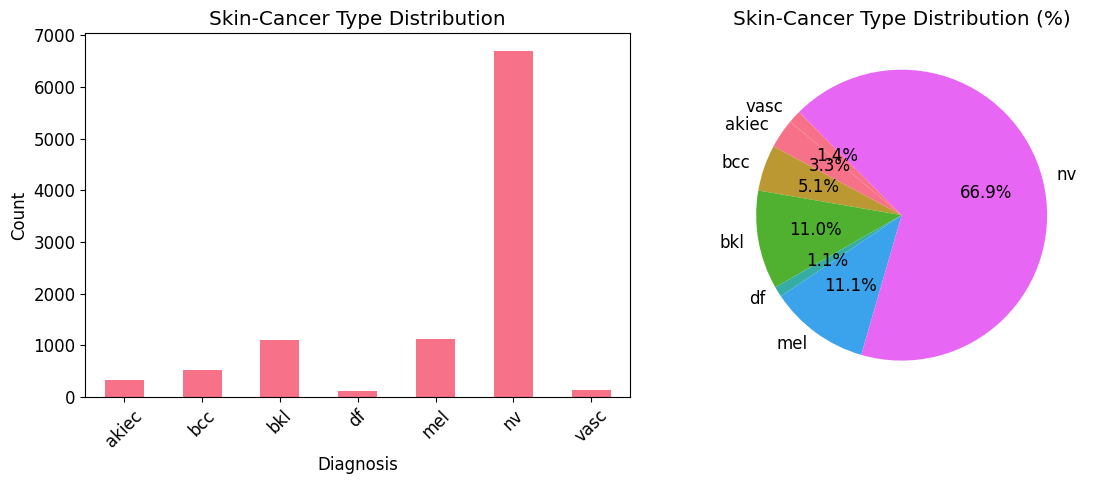


3. AGE DISTRIBUTION
count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64


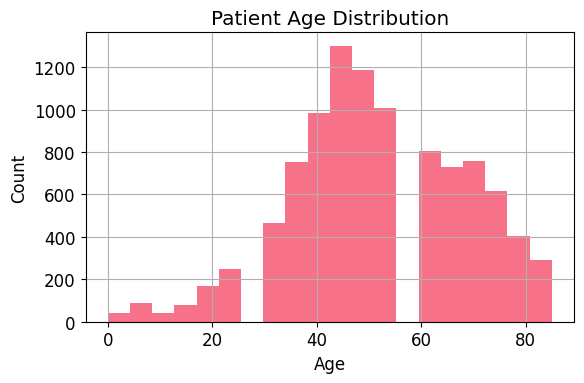


4. GENDER DISTRIBUTION
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64


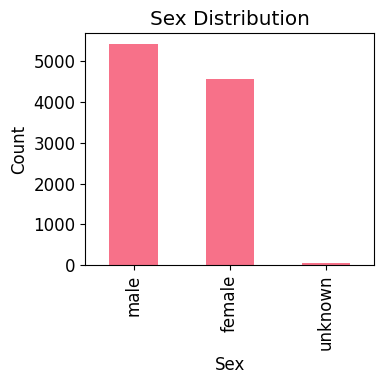


5. LOCALIZATION ANALYSIS (Top-10)
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
Name: count, dtype: int64


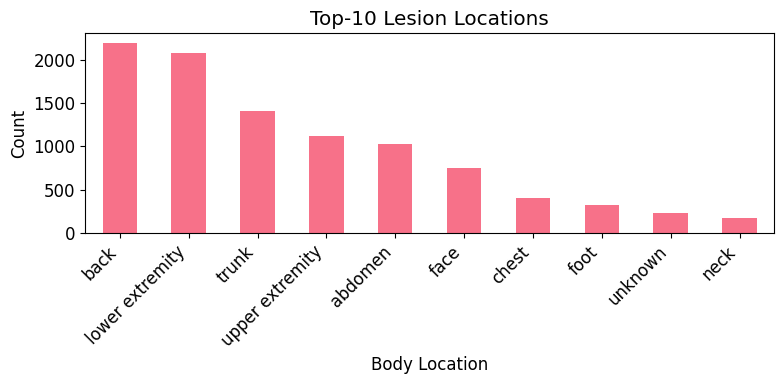


6. MISSING VALUE ANALYSIS
age    57
dtype: int64

7. AGE–vs–CLASS CORRELATION


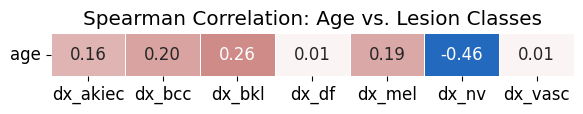


8. DATA-QUALITY CHECKS
{'duplicate_image_ids': 0, 'rows_with_missing_age': 57, 'total_rows': 10015}

=== PREPARING DATA FOR TABLEAU/POWERBI ===
Data exported to ham10000_for_tableau.csv for Tableau/PowerBI analysis
Exported dataset shape: (10015, 8)


In [ ]:
# TODO: SHELLY
# Feature Dataset Analysis Functions
def analyze_feature_dataset(df):
    """
    Comprehensive analysis of the HAM10000 metadata/feature dataset.

    Parameters:
    df (pandas.DataFrame): The metadata dataframe

    Returns:
    dict: Analysis results including statistics and quality metrics
    """
    analysis_results = {}

    print("=== FEATURE DATASET ANALYSIS ===")
    print(f"Dataset shape: {df.shape}")

    # ───────────────────────────────────────────────────────────────
    # 1. BASIC STATISTICS
    # ───────────────────────────────────────────────────────────────
    print("\n1. BASIC STATISTICS")
    analysis_results['basic_stats'] = df.describe(include='all')
    display(analysis_results['basic_stats'])

    # ───────────────────────────────────────────────────────────────
    # 2. CLASS DISTRIBUTION
    # ───────────────────────────────────────────────────────────────
    print("\n2. CLASS DISTRIBUTION")
    if 'dx' in df.columns:
        class_dist = df['dx'].value_counts().sort_index()
        analysis_results['class_distribution'] = class_dist
        print(class_dist)

        # Visualize class distribution
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        class_dist.plot(kind='bar')
        plt.title('Skin-Cancer Type Distribution')
        plt.xlabel('Diagnosis')
        plt.ylabel('Count')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.pie(class_dist.values,
                labels=class_dist.index,
                autopct='%1.1f%%', startangle=140)
        plt.title('Skin-Cancer Type Distribution (%)')
        plt.tight_layout()
        plt.show()

    # ───────────────────────────────────────────────────────────────
    # 3. AGE DISTRIBUTION
    # ───────────────────────────────────────────────────────────────
    if 'age' in df.columns:
        print("\n3. AGE DISTRIBUTION")
        age_desc = df['age'].describe()
        analysis_results['age_stats'] = age_desc
        print(age_desc)

        plt.figure(figsize=(6, 4))
        df['age'].hist(bins=20)
        plt.title('Patient Age Distribution')
        plt.xlabel('Age')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

    # ───────────────────────────────────────────────────────────────
    # 4. GENDER DISTRIBUTION
    # ───────────────────────────────────────────────────────────────
    if 'sex' in df.columns:
        print("\n4. GENDER DISTRIBUTION")
        sex_dist = df['sex'].value_counts()
        analysis_results['sex_distribution'] = sex_dist
        print(sex_dist)

        plt.figure(figsize=(4, 4))
        sex_dist.plot(kind='bar')
        plt.title('Sex Distribution')
        plt.xlabel('Sex')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

    # ───────────────────────────────────────────────────────────────
    # 5. LOCALIZATION ANALYSIS
    # ───────────────────────────────────────────────────────────────
    if 'localization' in df.columns:
        print("\n5. LOCALIZATION ANALYSIS (Top-10)")
        loc_dist = df['localization'].value_counts().head(10)
        analysis_results['localization_distribution'] = loc_dist
        print(loc_dist)

        plt.figure(figsize=(8, 4))
        loc_dist.plot(kind='bar')
        plt.title('Top-10 Lesion Locations')
        plt.xlabel('Body Location')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # ───────────────────────────────────────────────────────────────
    # 6. MISSING VALUE ANALYSIS
    # ───────────────────────────────────────────────────────────────
    print("\n6. MISSING VALUE ANALYSIS")
    missing_vals = df.isna().sum()
    analysis_results['missing_values'] = missing_vals
    print(missing_vals[missing_vals > 0])

   # ───────────────────────────────────────────────────────────────
# 7. AGE-vs-CLASS CORRELATION ANALYSIS
# ───────────────────────────────────────────────────────────────
    print("\n7. AGE–vs–CLASS CORRELATION")

    if 'age' in df.columns and 'dx' in df.columns:
        # ❶ Build dummy matrix for dx (drop_first=False keeps all 7 classes)
        dx_dummies = pd.get_dummies(df['dx'], prefix='dx')

        # ❷ Combine age + dummies → numeric matrix
        corr_df = pd.concat([df[['age']], dx_dummies], axis=1)

        # ❸ Compute Spearman (age is ordinal; dummies are binary)
        corr = corr_df.corr(method='spearman').loc[['age'], dx_dummies.columns]

        # ❹ Store & plot
        analysis_results['correlation_matrix'] = corr

        plt.figure(figsize=(6, 1.3))              # a single-row heat-map
        sns.heatmap(corr,
                    annot=True, fmt=".2f",
                    cmap="vlag", center=0,
                    cbar=False, linewidths=.5)
        plt.title('Spearman Correlation: Age vs. Lesion Classes')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    else:
        print("Required columns ('age' & 'dx') not found – skipping.")
        analysis_results['correlation_matrix'] = None


    # ───────────────────────────────────────────────────────────────
    # 8. BASIC DATA-QUALITY CHECKS
    # ───────────────────────────────────────────────────────────────
    print("\n8. DATA-QUALITY CHECKS")
    dq = {
        "duplicate_image_ids": int(df['image_id'].duplicated().sum()) if 'image_id' in df.columns else None,
        "rows_with_missing_age": int(df['age'].isna().sum()) if 'age' in df.columns else None,
        "total_rows": len(df)
    }
    analysis_results['data_quality'] = dq
    print(dq)

    return analysis_results


def create_tableau_export(df, filename='ham10000_for_tableau.csv'):
    """
    Prepare and export data for Tableau/PowerBI visualization.

    Parameters:
    df (pandas.DataFrame): The metadata dataframe
    filename (str): Output filename for export
    """
    print("\n=== PREPARING DATA FOR TABLEAU/POWERBI ===")

    export_df = df.copy()

    # Derived feature: age group (optional)
    if 'age' in export_df.columns:
        export_df['age_group'] = pd.cut(
            export_df['age'],
            bins=[0, 30, 50, 70, 100],
            labels=['<30', '30-49', '50-69', '70+'],
            right=False
        )

    export_df.to_csv(filename, index=False)
    print(f"Data exported to {filename} for Tableau/PowerBI analysis")
    print(f"Exported dataset shape: {export_df.shape}")


# Execute feature analysis if data is loaded
if 'metadata_df' in globals() and metadata_df is not None:
    feature_analysis = analyze_feature_dataset(metadata_df)
    create_tableau_export(metadata_df)
else:
    print("Cannot perform feature analysis – metadata_df not found")


## CRISP-DM Phase 5: Data Understanding - Image Dataset Analysis

**Assigned to:** Dalal El Amine
**Purpose:** Analyze the image dataset, understand image properties, and display sample images.
**Expected Outcomes:** Understanding of image dimensions, quality, class distribution, and visual characteristics.

Starting image dataset analysis …
=== IMAGE DATASET ANALYSIS ===
Assigned to: Dalal El Amine

1. IMAGE AVAILABILITY ANALYSIS
   • Images on disk           : 10,015
   • Metadata records         : 10,015
   • Missing images           : 0
   • Duplicate image_id rows  : 0

2. IMAGE PROPERTIES ANALYSIS


Scanning dimensions: 100%|██████████| 2000/2000 [00:00<00:00, 16148.21it/s]



3. IMAGE CLASS DISTRIBUTION
dx
akiec     327
bcc       514
bkl      1099
df        115
mel      1113
nv       6705
vasc      142
Name: count, dtype: int64

4. SAMPLE IMAGES DISPLAY

=== SAMPLE IMAGES BY CLASS ===
Found 7 classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


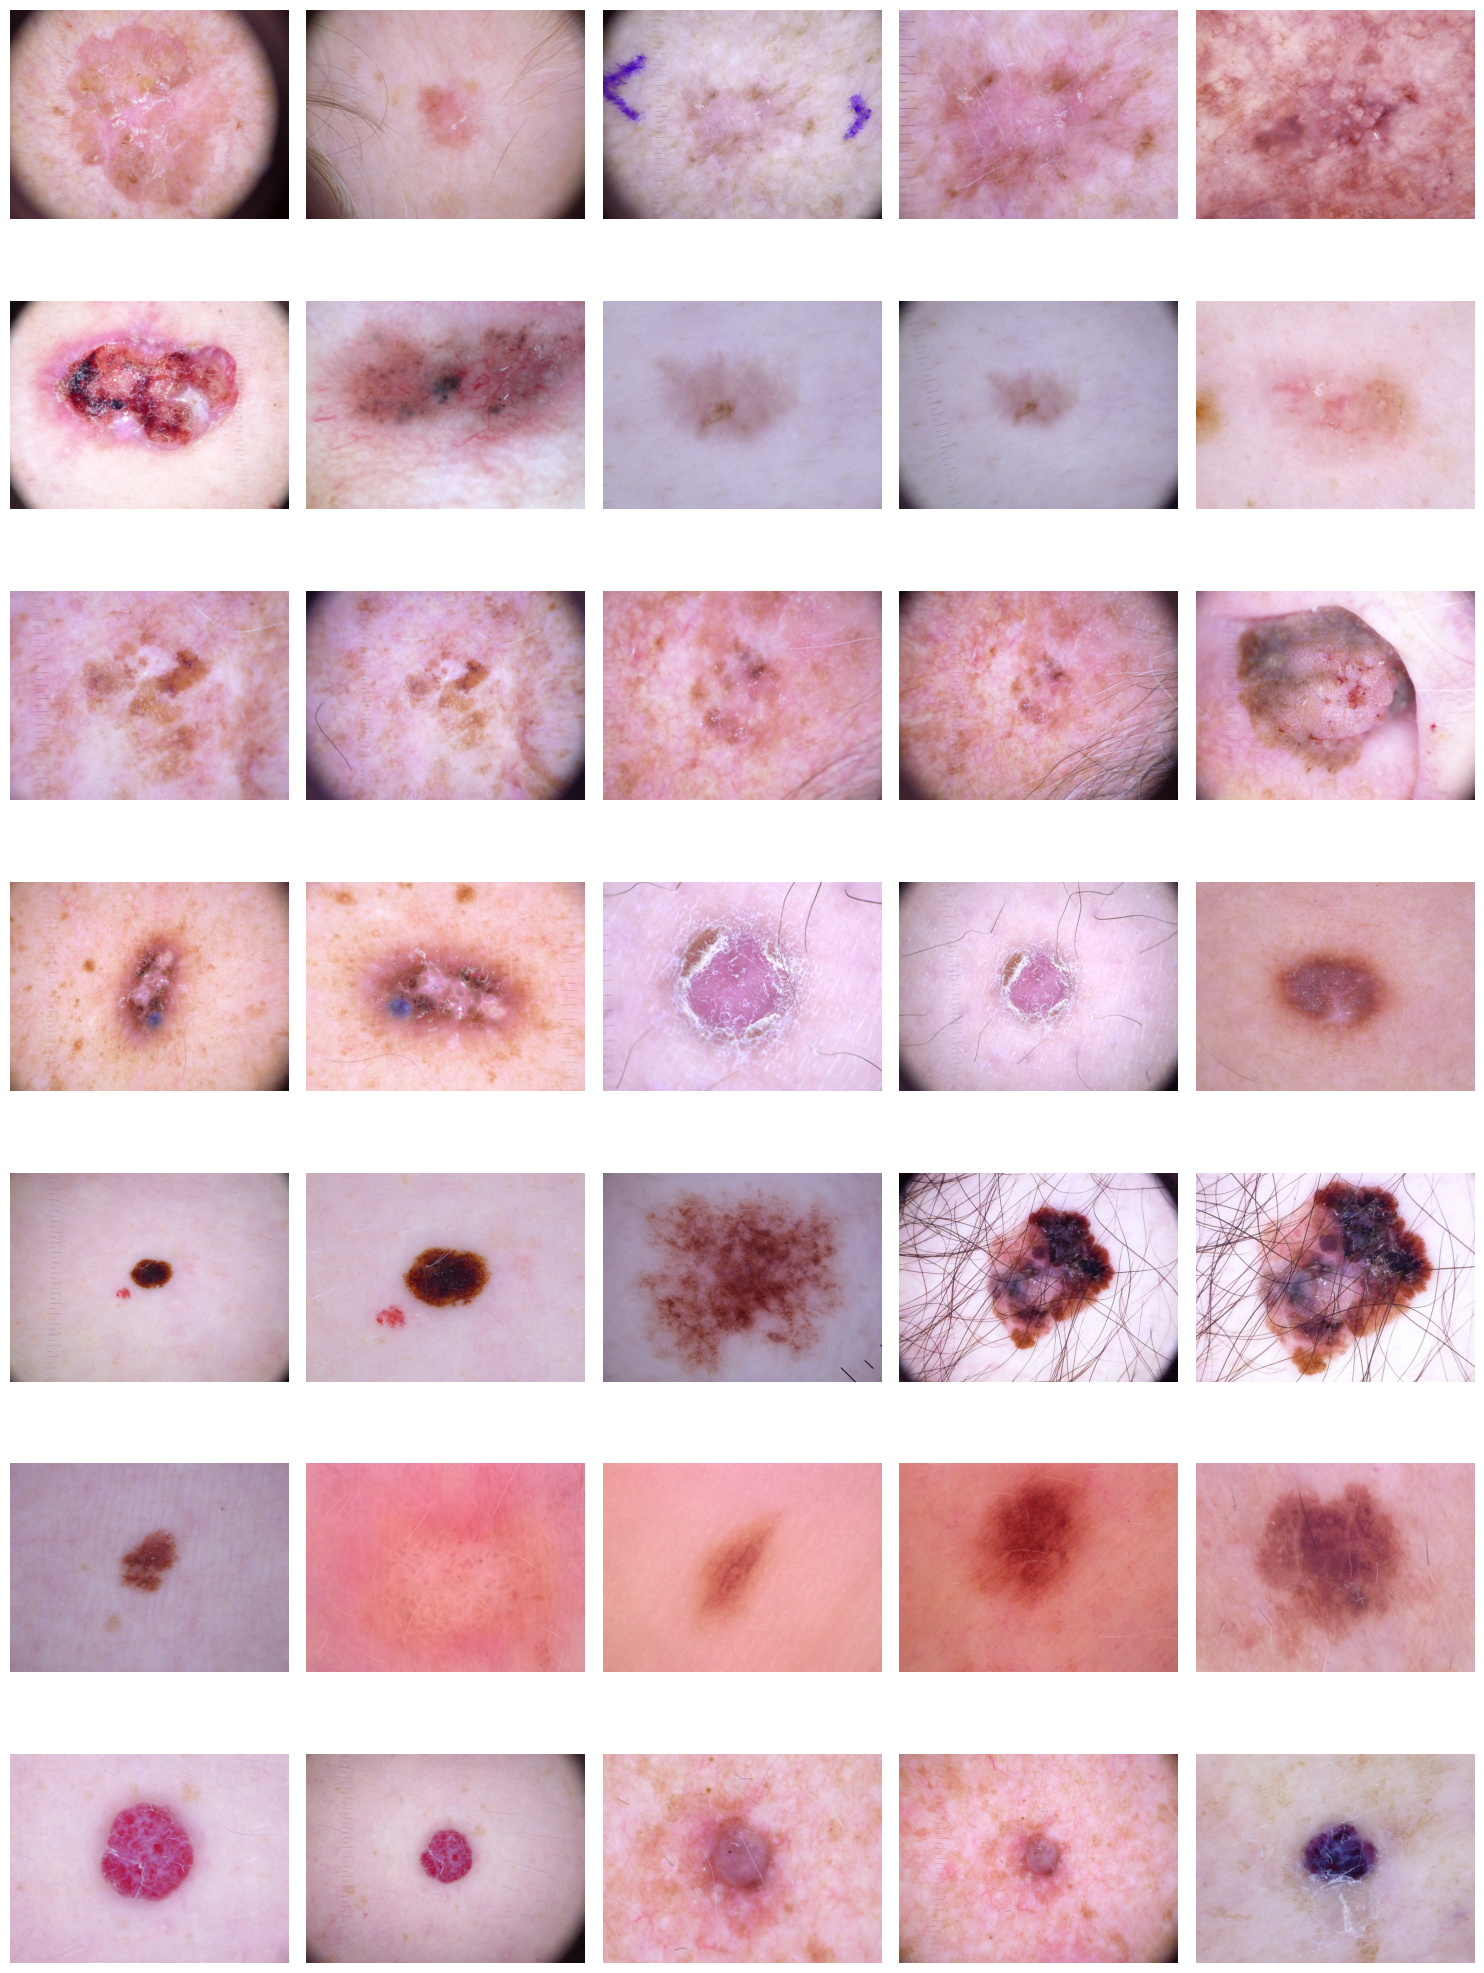


=== IMAGE COLOR ANALYSIS ===


Color sampling: 100%|██████████| 100/100 [00:01<00:00, 98.52it/s]


Average normalized RGB across sample: {'R': np.float64(0.768881540159676), 'G': np.float64(0.5578057938997234), 'B': np.float64(0.5820682360202497)}


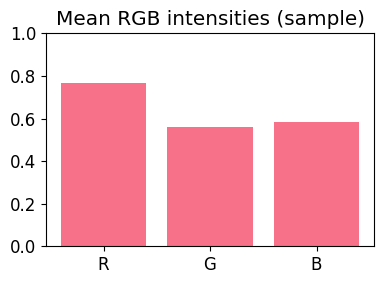

In [ ]:
# TODO: DALAL - IMPLEMENT IMAGE DATASET ANALYSIS
# Image Dataset Analysis Functions
import os, random, math, glob
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# ─────────────────────────────────────────────────────────────────────────────
def analyze_image_dataset(metadata_df, images_path):
    """
    Comprehensive analysis of the HAM10000 image dataset.
    Returns a dict of key statistics & plots saved to ./outputs/img_analysis/
    """
    print("=== IMAGE DATASET ANALYSIS ===")
    print("Assigned to: Dalal El Amine")

    out_dir = Path("./outputs/img_analysis")
    out_dir.mkdir(parents=True, exist_ok=True)

    analysis_results = {}

    # 1️⃣ IMAGE AVAILABILITY ----------------------------------------------------
    print("\n1. IMAGE AVAILABILITY ANALYSIS")
    img_files = list(Path(images_path).glob("*.jp*g"))
    img_names = set(p.stem for p in img_files)

    total_meta = len(metadata_df)
    missing_imgs = metadata_df[~metadata_df["image_id"].isin(img_names)]
    duplicate_imgs = metadata_df["image_id"].duplicated().sum()

    print(f"   • Images on disk           : {len(img_files):,}")
    print(f"   • Metadata records         : {total_meta:,}")
    print(f"   • Missing images           : {len(missing_imgs):,}")
    print(f"   • Duplicate image_id rows  : {duplicate_imgs}")

    analysis_results["image_count"] = len(img_files)
    analysis_results["missing_images"] = missing_imgs["image_id"].tolist()
    analysis_results["duplicate_rows"] = int(duplicate_imgs)

    # 2️⃣ IMAGE PROPERTIES ------------------------------------------------------
    print("\n2. IMAGE PROPERTIES ANALYSIS")
    dims, file_sizes = [], []
    for p in tqdm(random.sample(img_files, k=min(2000, len(img_files))),
                  desc="Scanning dimensions"):
        with Image.open(p) as im:
            dims.append(im.size)  # (width, height)
        file_sizes.append(p.stat().st_size / 1024)  # KiB

    dims_arr = np.array(dims)
    analysis_results["dim_stats"] = {
        "width":  dims_arr[:,0].tolist(),
        "height": dims_arr[:,1].tolist()
    }
    analysis_results["file_size_kib"] = file_sizes

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    sns.histplot(dims_arr[:,0], bins=20, ax=axes[0])
    axes[0].set_title("Width distribution")
    sns.histplot(file_sizes, bins=20, ax=axes[1])
    axes[1].set_title("File-size (KiB)")
    plt.tight_layout()
    plt.savefig(out_dir/"img_props.png"); plt.close()

    # 3️⃣ CLASS DISTRIBUTION (images) ------------------------------------------
    print("\n3. IMAGE CLASS DISTRIBUTION")
    class_counts = metadata_df["dx"].value_counts().sort_index()
    analysis_results["class_distribution"] = class_counts.to_dict()
    print(class_counts)

    plt.figure(figsize=(7,4))
    class_counts.plot(kind="bar")
    plt.title("Image count per class")
    plt.ylabel("Images")
    plt.tight_layout()
    plt.savefig(out_dir/"img_class_dist.png"); plt.close()

    # 4️⃣ SAMPLE GRID -----------------------------------------------------------
    print("\n4. SAMPLE IMAGES DISPLAY")
    display_sample_images_by_class(metadata_df, images_path)

    return analysis_results

# ─────────────────────────────────────────────────────────────────────────────
def display_sample_images_by_class(metadata_df, images_path, samples_per_class=5):
    """
    Display first N images per class; one row per class.
    """
    print("\n=== SAMPLE IMAGES BY CLASS ===")
    unique_classes = sorted(metadata_df["dx"].unique())
    print(f"Found {len(unique_classes)} classes: {unique_classes}")

    n_rows, n_cols = len(unique_classes), samples_per_class
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols*3, n_rows*3),
                             squeeze=False)

    for r, cls in enumerate(unique_classes):
        cls_rows = metadata_df[metadata_df["dx"] == cls].head(samples_per_class)
        for c in range(samples_per_class):
            ax = axes[r, c]
            ax.axis("off")
            try:
                img_id = cls_rows.iloc[c]["image_id"]
                img_path = Path(images_path) / f"{img_id}.jpg"
                if img_path.exists():
                    ax.imshow(Image.open(img_path))
                if c == 0:
                    ax.set_ylabel(cls, rotation=0, size="large", labelpad=40)
            except IndexError:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center")
    plt.tight_layout()
    plt.show()

# ─────────────────────────────────────────────────────────────────────────────
def analyze_image_color_properties(metadata_df, images_path, sample_size=100):
    """
    Analyze RGB channel distributions & dominant colors for a sample of images.
    """
    print("\n=== IMAGE COLOR ANALYSIS ===")
    sample_ids = random.sample(metadata_df["image_id"].tolist(),
                               k=min(sample_size, len(metadata_df)))
    channel_sums = np.zeros((3,))

    for img_id in tqdm(sample_ids, desc="Color sampling"):
        path = Path(images_path) / f"{img_id}.jpg"
        if not path.exists():
            continue
        im = np.array(Image.open(path).convert("RGB")) / 255.0
        channel_sums += im.mean(axis=(0,1))

    avg_rgb = channel_sums / len(sample_ids)
    print("Average normalized RGB across sample:", dict(R=avg_rgb[0],
                                                        G=avg_rgb[1],
                                                        B=avg_rgb[2]))

    plt.figure(figsize=(4,3))
    plt.bar(["R","G","B"], avg_rgb)
    plt.ylim(0,1)
    plt.title("Mean RGB intensities (sample)")
    plt.tight_layout()
    plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Execute image analysis if data is loaded
if ('metadata_df' in globals() and metadata_df is not None and
    'image_files' in globals() and len(image_files) > 0):
    print("Starting image dataset analysis …")
    image_analysis = analyze_image_dataset(metadata_df, IMAGES_PATH)
    analyze_image_color_properties(metadata_df, IMAGES_PATH)
else:
    print("Cannot perform image analysis – data not loaded or images missing")


[link text](https://)## CRISP-DM Phase 6: Data Preparation - Feature Dataset Processing

**Purpose:** Create the required 5 datasets and apply preprocessing techniques.
**Required Datasets:** Original, Normalized, Standardized, PCA-reduced, LDA-reduced
**Expected Outcomes:** 5 prepared datasets ready for modeling, SMOTE applied for imbalance.

In [ ]:
# ## TODO: SHELLY
# Data Preparation Functions - Feature Dataset

# ---------------------------------------------------------------------------
#  helper – drop IDs, impute, encode ALL categoricals, feature-select
# ---------------------------------------------------------------------------
from sklearn.feature_selection import VarianceThreshold

def _feature_engineering(df):
    """
    Clean HAM10000 metadata, engineer numeric features, and run a light
    variance-threshold feature-selection step.
    Returns a DataFrame containing ONLY predictive features + 'dx'.
    """
    df_fe = df.copy()

    # 0️⃣  Drop pure identifiers
    df_fe.drop(columns=[c for c in ['image_id', 'lesion_id'] if c in df_fe.columns],
               inplace=True)

    # 1️⃣  Impute missing age
    if 'age' in df_fe.columns:
        df_fe['age'].fillna(df_fe['age'].median(), inplace=True)

    # 2️⃣  One-hot encode *all* remaining object categoricals except 'dx'
    obj_cols = [c for c in df_fe.select_dtypes(include='object').columns
                if c != 'dx']
    df_fe = pd.get_dummies(df_fe, columns=obj_cols, drop_first=True)

    # 3️⃣  Ensure numeric dtypes (bool → int)
    bool_cols = df_fe.select_dtypes(include='bool').columns
    df_fe[bool_cols] = df_fe[bool_cols].astype(int)

    # 4️⃣  Variance-threshold feature selection
    y = df_fe['dx']
    X = df_fe.drop(columns=['dx'])
    selector = VarianceThreshold(threshold=0.0)       # drop zero-variance cols
    X_sel = X.loc[:, selector.fit(X).get_support()]

    feature_df = X_sel.copy()
    feature_df['dx'] = y.values

    print(f"   • Feature-engineering complete: {X_sel.shape[1]} predictors retained.")
    return feature_df



def _assemble_dataset(X, y, feature_names):
    """Return a DataFrame with features + target (`dx`)."""
    df_out = pd.DataFrame(X, columns=feature_names)
    df_out['dx'] = y.reset_index(drop=True)
    return df_out
# -----------------------------------------------------------------------------

def prepare_feature_datasets(metadata_df):
    """
    Create the required 5 datasets for machine learning tasks.

    Parameters:
    metadata_df (pandas.DataFrame): Original metadata

    Returns:
    dict: Dictionary containing all 5 prepared datasets
    """
    print("=== FEATURE DATASET PREPARATION ===")
    print("Creating 5 required datasets: Original, Normalized, Standardized, "
          "PCA-reduced, LDA-reduced")

    datasets = {}

    # 1️⃣  FEATURE ENGINEERING ---------------------------------------------------
    print("\n1. FEATURE ENGINEERING …")
    df_fe = _feature_engineering(metadata_df)
    y = df_fe['dx']
    # Drop 'dx', 'image_id', and 'lesion_id' before scaling
    X = df_fe.drop(columns=['dx', 'image_id', 'lesion_id'], errors='ignore')
    base_feature_names = X.columns.tolist()
    print(f"   • Engineered feature matrix shape: {X.shape}")

    # 2️⃣  ORIGINAL --------------------------------------------------------------
    print("\n2. CREATING ORIGINAL DATASET")
    datasets['original'] = _assemble_dataset(X, y, base_feature_names)

    # 3️⃣  NORMALIZED ------------------------------------------------------------
    print("\n3. CREATING NORMALIZED DATASET")
    mm_scaler = MinMaxScaler()
    X_norm = mm_scaler.fit_transform(X)          # use the modified X
    datasets['normalized'] = _assemble_dataset(X_norm, y, base_feature_names)

    # 4️⃣  STANDARDIZED ----------------------------------------------------------
    print("\n4. CREATING STANDARDIZED DATASET")
    std_scaler = StandardScaler()
    X_std = std_scaler.fit_transform(X)          # use the modified X
    datasets['standardized'] = _assemble_dataset(X_std, y, base_feature_names)

    # 5️⃣  PCA-REDUCED -----------------------------------------------------------
    print("\n5. CREATING PCA-REDUCED DATASET")
    pca = PCA(n_components=0.80, random_state=42)
    X_pca = pca.fit_transform(X_std)          # use standardized features
    pca_cols = [f"pca_{i+1}" for i in range(X_pca.shape[1])]
    datasets['pca_reduced'] = _assemble_dataset(X_pca, y, pca_cols)
    print(f"   • PCA components kept: {X_pca.shape[1]} "
          f"(≥ 80 % var explained)")

    # 6️⃣  LDA-REDUCED -----------------------------------------------------------
    print("\n6. CREATING LDA-REDUCED DATASET")
    n_components = len(y.unique()) - 1
    lda = LDA(n_components=n_components)
    X_lda = lda.fit_transform(X_std, y)
    lda_cols = [f"lda_{i+1}" for i in range(X_lda.shape[1])]
    datasets['lda_reduced'] = _assemble_dataset(X_lda, y, lda_cols)

    # 7️⃣  (Optional) save scalers / models for inference ------------------------
    # e.g., joblib.dump(std_scaler, 'std_scaler.joblib')

    print("\n✅ Base datasets created:", ', '.join(datasets.keys()))
    return datasets


def apply_smote_to_datasets(datasets, target_column='dx'):
    """
    Apply SMOTE (Synthetic Minority Oversampling Technique) to handle class imbalance.

    Parameters:
    datasets (dict): Dictionary of prepared datasets
    target_column (str): Name of target column

    Returns:
    dict: Datasets with SMOTE applied
    """
    print("\n=== APPLYING SMOTE FOR CLASS IMBALANCE ===")

    smote_datasets = {}
    smote = SMOTE(random_state=42)

    for name, df in datasets.items():
        print(f"→ Processing {name} …")
        X = df.drop(target_column, axis=1)
        y = df[target_column]
        X_resampled, y_resampled = smote.fit_resample(X, y)
        smote_df = _assemble_dataset(X_resampled, y_resampled, X.columns)
        smote_datasets[f"{name}_smote"] = smote_df
        print(f"   • Resampled shape: {smote_df.shape}")

    # 🔸 Print class distribution after SMOTE
        print("   • Post-SMOTE class counts:")
        print(y_resampled.value_counts().sort_index())

    print("\n✅ SMOTE-augmented datasets:", ', '.join(smote_datasets.keys()))
    return smote_datasets


# Execute feature dataset preparation if data is loaded
if 'metadata_df' in globals() and metadata_df is not None:
    prepared_datasets = prepare_feature_datasets(metadata_df)
    smote_datasets = apply_smote_to_datasets(prepared_datasets)
    print(f"\nDataset preparation completed. "
          f"Created {len(prepared_datasets)} base datasets "
          f"and {len(smote_datasets)} SMOTE-balanced datasets.")
else:
    print("Cannot prepare datasets – metadata_df not loaded")

=== FEATURE DATASET PREPARATION ===
Creating 5 required datasets: Original, Normalized, Standardized, PCA-reduced, LDA-reduced

1. FEATURE ENGINEERING …
   • Feature-engineering complete: 20 predictors retained.
   • Engineered feature matrix shape: (10015, 20)

2. CREATING ORIGINAL DATASET

3. CREATING NORMALIZED DATASET

4. CREATING STANDARDIZED DATASET

5. CREATING PCA-REDUCED DATASET
   • PCA components kept: 14 (≥ 80 % var explained)

6. CREATING LDA-REDUCED DATASET

✅ Base datasets created: original, normalized, standardized, pca_reduced, lda_reduced

=== APPLYING SMOTE FOR CLASS IMBALANCE ===
→ Processing original …
   • Resampled shape: (46935, 21)
   • Post-SMOTE class counts:
dx
akiec    6705
bcc      6705
bkl      6705
df       6705
mel      6705
nv       6705
vasc     6705
Name: count, dtype: int64
→ Processing normalized …
   • Resampled shape: (46935, 21)
   • Post-SMOTE class counts:
dx
akiec    6705
bcc      6705
bkl      6705
df       6705
mel      6705
nv       6705
v

## CRISP-DM Phase 7: Data Preparation - CNN Feature Extraction

**Purpose:** Build CNN model for feature extraction and preprocess images.
**Requirements:** CNN with convolution, pooling, dropout layers only. Display before/after convolution.
**Expected Outcomes:** Extracted features for clustering and outlier detection tasks.

In [ ]:
## TODO: SHELLY
# CNN Feature Extraction for Image Dataset
import os, json, random, pathlib, numpy as np, tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import layers, models

# ─────────────────────────────────────────────────────────────────────────────
def build_cnn_feature_extractor(input_shape=(224, 224, 3)):
    """
    Build CNN model for feature extraction only (no classification layers).
    Requirements: convolution, pooling, and dropout layers only.

    Parameters:
    input_shape (tuple): Input image shape

    Returns:
    tensorflow.keras.Model: CNN feature extractor model
    """
    print("=== BUILDING CNN FEATURE EXTRACTOR ===")
    print("Requirements: Convolution, pooling, and dropout layers only")

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.GlobalAveragePooling2D(),  # feature vector
        layers.Dropout(0.5)
    ])

    model.summary()
    return model
# ─────────────────────────────────────────────────────────────────────────────
def run_image_feature_pipeline(
        metadata_df,
        images_path,
        output_dir="prepared/image",
        img_size=(224, 224),
        batch_size=32,
        val_split=0.15,
        test_split=0.15,
        seed=42):
    """
    End-to-end helper:
    1.  Splits image IDs into train/val/test (or loads existing JSON)
    2.  Builds tf.data pipelines
    3.  Extracts features with the CNN backbone
    4.  Saves *.npz feature files for each split
    """

    # 0️⃣ paths
    output_dir = pathlib.Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    split_file = output_dir / "splits.json"

    # 1️⃣ (Re)create / load splits
    if split_file.exists():
        splits = json.load(open(split_file))
        print("✅ Loaded existing split file:", split_file)
    else:
        ids = metadata_df["image_id"].tolist()
        random.Random(seed).shuffle(ids)
        n_total = len(ids)
        n_test  = int(test_split * n_total)
        n_val   = int(val_split  * n_total)
        splits = {
            "test": ids[:n_test],
            "val" : ids[n_test:n_test + n_val],
            "train": ids[n_test + n_val:]
        }
        json.dump(splits, open(split_file, "w"))
        print("✅ New splits saved →", split_file)

    # 2️⃣ tf.data helper
    AUTOTUNE = tf.data.AUTOTUNE
    def make_ds(id_list, shuffle=True):
        paths = [str(pathlib.Path(images_path) / f"{img_id}.jpg") for img_id in id_list]
        labels = [metadata_df.loc[metadata_df["image_id"] == img_id, "dx"].values[0]
                  for img_id in id_list]
        label_table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(
                keys=tf.constant(metadata_df["dx"].unique()),
                values=tf.constant(list(range(metadata_df["dx"].nunique())))),
            default_value=-1)
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        if shuffle:
            ds = ds.shuffle(len(paths), seed=seed)
        ds = ds.map(lambda p, y: (
            tf.image.resize(tf.io.decode_jpeg(tf.io.read_file(p), channels=3), img_size),
            label_table.lookup(tf.cast(y, tf.string))),
            num_parallel_calls=AUTOTUNE
        )
        ds = ds.batch(batch_size).prefetch(AUTOTUNE)
        return ds

    train_ds = make_ds(splits["train"])
    val_ds   = make_ds(splits["val"], shuffle=False)
    test_ds  = make_ds(splits["test"], shuffle=False)

    # 3️⃣ Build extractor & loop through splits
    extractor = build_cnn_feature_extractor(input_shape=img_size + (3,))
    @tf.function
    def _infer(batch):  # TF-graph for speed
        return extractor(batch, training=False)

    for split_name, ds in zip(["train", "val", "test"], [train_ds, val_ds, test_ds]):
        print(f"\n⏳ Extracting {split_name} features …")
        features, labels = [], []
        for batch, lab in tqdm(ds, total=len(ds)):
            feats = _infer(batch)
            features.append(feats.numpy())
            labels.append(lab.numpy())
        X = np.vstack(features)
        y = np.concatenate(labels)
        np.savez_compressed(output_dir / f"features_{split_name}.npz", X=X, y=y)
        print(f"✅ Saved {split_name} features → {output_dir/f'features_{split_name}.npz'} "
              f"(shape={X.shape})")

    return extractor
# ─────────────────────────────────────────────────────────────────────────────

# Execute CNN feature extraction if data is loaded
if ('metadata_df' in globals() and metadata_df is not None and
    'IMAGES_PATH' in globals() and len(list(pathlib.Path(IMAGES_PATH).glob("*.jpg"))) > 0):

    print("Starting CNN feature extraction pipeline …")
    cnn_extractor = run_image_feature_pipeline(metadata_df,
                                               images_path=IMAGES_PATH)
    print("\n🌟 CNN feature-extraction phase complete.")
else:
    print("Cannot build CNN feature extractor – data or image files not loaded.")


Starting CNN feature extraction pipeline …
✅ New splits saved → prepared/image/splits.json
=== BUILDING CNN FEATURE EXTRACTOR ===
Requirements: Convolution, pooling, and dropout layers only


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)


⏳ Extracting train features …


100%|██████████| 220/220 [00:38<00:00,  5.72it/s]


✅ Saved train features → prepared/image/features_train.npz (shape=(7011, 128))

⏳ Extracting val features …


100%|██████████| 47/47 [00:08<00:00,  5.78it/s]


✅ Saved val features → prepared/image/features_val.npz (shape=(1502, 128))

⏳ Extracting test features …


100%|██████████| 47/47 [00:08<00:00,  5.67it/s]


✅ Saved test features → prepared/image/features_test.npz (shape=(1502, 128))

🌟 CNN feature-extraction phase complete.


## CRISP-DM Phase 8: Classification Implementation

**Assigned to:** Shelly Tyagi
**Purpose:** Implement classification algorithms for both feature and image datasets.
**Required Algorithms:** Naive Bayes, SVM, MLP, Stacking (NB+SVM+MLP base, LogReg meta), CNN
**Expected Outcomes:** Trained classification models with performance metrics.

In [ ]:
# ============================================================================
# FEATURE DATASET CLASSIFICATION (Shelly Tyagi) – best-params, no grid-search
# ============================================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.base import clone
from collections import defaultdict

def implement_feature_classification(datasets, models,
                                     test_size=0.2, random_state=42):
    """
    Train each estimator in `models` on every dataset in `datasets`.

    Parameters:
    -----------
    datasets : dict of dicts
       e.g. {"base": prepared_datasets, "smote": smote_datasets}
       each inner dict maps name→DataFrame with a 'dx' column.
    models : dict
       name→pre-instantiated sklearn-like estimator (already set to best params).
    test_size : float
    random_state : int

    Returns:
    --------
    results : dict
      Nested metrics: results[dataset_key][model_name] = {
          "model": fitted_estimator,
          "accuracy": ...,
          "precision": ...,
          "recall": ...,
          "f1": ...
      }
    """
    print("=== FEATURE DATASET CLASSIFICATION ===")
    print("Assigned to: Shelly Tyagi")
    print(f"Models: {list(models.keys())}\n")

    results = defaultdict(dict)

    for ds_type, ds_dict in datasets.items():
        for ds_name, df in ds_dict.items():
            key = f"{ds_type}_{ds_name}"
            X = df.drop("dx", axis=1).values
            y = df["dx"].values

            X_train, X_test, y_train, y_test = train_test_split(
                X, y,
                test_size=test_size,
                random_state=random_state,
                stratify=y
            )

            print(f"\n🔹 DATASET: {key}  (shape={df.shape})")
            for model_name, estimator in models.items():
                print(f"  • Training {model_name} …", end=" ")
                m = clone(estimator)
                m.fit(X_train, y_train)
                y_pred = m.predict(X_test)

                acc = accuracy_score(y_test, y_pred)
                prec, rec, f1, _ = precision_recall_fscore_support(
                    y_test, y_pred, average="macro", zero_division=0
                )

                print(f"✔ Acc {acc:.3f}  F1 {f1:.3f}")
                results[key][model_name] = {
                    "model": m,
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1
                }

    return results

# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression

# 1) Define your best‐param models:
models = {
  "NaiveBayes": GaussianNB(),
  "SVM"       : SVC(C=1, kernel="rbf", probability=True),
  "MLP"       : MLPClassifier(hidden_layer_sizes=(100,), alpha=1e-4,
                              max_iter=200, random_state=42),
  "Stacking"  : StackingClassifier(
                   estimators=[
                     ("nb", GaussianNB()),
                     ("svm", SVC(C=1, kernel="rbf", probability=True)),
                     ("mlp", MLPClassifier(hidden_layer_sizes=(100,),
                                           alpha=1e-4, max_iter=200,
                                           random_state=42))
                   ],
                   final_estimator=LogisticRegression(max_iter=200),
                   cv=3, n_jobs=-1)
}

# 2) Package your two dataset dicts:
all_datasets = {
  "base" : prepared_datasets,
  "smote": smote_datasets
}

# 3) Run the loop:
feature_results = implement_feature_classification(all_datasets, models)


=== FEATURE DATASET CLASSIFICATION ===
Assigned to: Shelly Tyagi
Models: ['NaiveBayes', 'SVM', 'MLP', 'Stacking']


🔹 DATASET: base_original  (shape=(10015, 21))
  • Training NaiveBayes … ✔ Acc 0.409  F1 0.164
  • Training SVM … ✔ Acc 0.672  F1 0.121
  • Training MLP … ✔ Acc 0.699  F1 0.320
  • Training Stacking … ✔ Acc 0.702  F1 0.289

🔹 DATASET: base_normalized  (shape=(10015, 21))
  • Training NaiveBayes … ✔ Acc 0.407  F1 0.162
  • Training SVM … ✔ Acc 0.712  F1 0.257
  • Training MLP … ✔ Acc 0.710  F1 0.306
  • Training Stacking … ✔ Acc 0.710  F1 0.292

🔹 DATASET: base_standardized  (shape=(10015, 21))
  • Training NaiveBayes … ✔ Acc 0.408  F1 0.163
  • Training SVM … ✔ Acc 0.715  F1 0.278
  • Training MLP … ✔ Acc 0.714  F1 0.369
  • Training Stacking … ✔ Acc 0.713  F1 0.344

🔹 DATASET: base_pca_reduced  (shape=(10015, 15))
  • Training NaiveBayes … ✔ Acc 0.318  F1 0.192
  • Training SVM … ✔ Acc 0.711  F1 0.253
  • Training MLP … ✔ Acc 0.712  F1 0.299
  • Training Stacking … ✔ Acc 

In [ ]:


def implement_image_classification(cnn_features, image_labels, raw_images=None):
    """
    Implement classification algorithms for image datasets.
    Required: Naive Bayes, SVM, MLP (on CNN features), CNN (on raw images)

    Parameters:
    cnn_features (numpy.ndarray): Features extracted by CNN
    image_labels (numpy.ndarray): Image labels
    raw_images (numpy.ndarray): Raw images for CNN classification

    Returns:
    dict: Trained classification models and results
    """
    print("\n=== IMAGE DATASET CLASSIFICATION ===")
    print("Required: NB, SVM, MLP (on CNN features), CNN (on raw images)")

    image_classification_results = {}

    # TODO: SHELLY - Implement the following:

    # 1. Naive Bayes on CNN features
    print("\n1. NAIVE BAYES ON CNN FEATURES")
    # - Apply NB to extracted CNN features

    # 2. SVM on CNN features
    print("\n2. SVM ON CNN FEATURES")
    # - Apply SVM to extracted CNN features

    # 3. MLP on CNN features
    print("\n3. MLP ON CNN FEATURES")
    # - Apply MLP to extracted CNN features

    # 4. CNN Classification
    print("\n4. CNN CLASSIFICATION")
    # - Build full CNN with classification layers
    # - Train on raw images
    # - Compare with feature-based approaches

    return image_classification_results

In [ ]:


def evaluate_classification_models(models, X_test, y_test):
    """
    Evaluate classification models and compute required metrics.
    Required metrics: accuracy, precision, recall, F1-score

    Parameters:
    models (dict): Trained classification models
    X_test (numpy.ndarray): Test features
    y_test (numpy.ndarray): Test labels

    Returns:
    dict: Evaluation metrics for all models
    """
    print("\n=== CLASSIFICATION EVALUATION ===")
    print("Required metrics: accuracy, precision, recall, F1-score")

    evaluation_results = {}

    # TODO: SHELLY - Implement evaluation for all models
    # - Calculate accuracy, precision, recall, F1-score
    # - Create confusion matrices
    # - Generate classification reports
    # - Compare model performances

    return evaluation_results

# Execute classification if datasets are prepared
print("=== CLASSIFICATION SECTION ===")
print("Assigned to: Shelly Tyagi")
print("TODO: Implement all classification algorithms and evaluations")

## CRISP-DM Phase 9: Clustering Implementation

**Assigned to:** Dalal El Amine
**Purpose:** Implement clustering algorithms for both feature and image datasets.
**Required Algorithms:** k-Means, DBSCAN, EM (Expectation Maximization)
**Expected Outcomes:** Clustering results with optimal k determination and cluster analysis.

## Data Preparation
First step here is to remove the duplicates in metadata and keep it in image dataset

In [ ]:
import pandas as pd

# Load the original metadata
df = pd.read_csv("HAM10000_metadata.csv")

# Lesion-level dataset: remove duplicate lesion_ids
lesion_df = df.drop_duplicates(subset='lesion_id')[['lesion_id', 'dx', 'age', 'sex', 'localization']]

# Image-level dataset: keep image_id and dx only
image_df = df[['image_id', 'dx']]

# Optional: save them
lesion_df.to_csv("lesion_level_metadata.csv", index=False)
image_df.to_csv("image_level_metadata.csv", index=False)

# Show head of both
lesion_df.head(), image_df.head()


In this step we need to construct the dataset

In [ ]:
# TODO: DALAL - IMPLEMENT CLUSTERING ALGORITHMS
# Clustering Implementation

def implement_feature_clustering(datasets):
    """
    Implement clustering algorithms for feature datasets.
    Required: k-Means, DBSCAN, EM

    Parameters:
    datasets (dict): Prepared feature datasets

    Returns:
    dict: Clustering results and analysis
    """
    print("=== FEATURE DATASET CLUSTERING ===")
    print("Assigned to: Dalal El Amine")
    print("Required algorithms: k-Means, DBSCAN, EM")

    clustering_results = {}

    # TODO: DALAL - Implement the following:

    # 1. k-Means Clustering
    print("\n1. K-MEANS CLUSTERING")
    # - Find optimal k using elbow method and silhouette analysis
    # - Apply k-means to all 5 datasets
    # - Analyze cluster characteristics
    # - Explain why instances are clustered together

    # 2. DBSCAN Clustering
    print("\n2. DBSCAN CLUSTERING")
    # - Optimize eps and min_samples parameters
    # - Apply to all datasets
    # - Handle noise points
    # - Compare with k-means results

    # 3. EM (Gaussian Mixture) Clustering
    print("\n3. EM CLUSTERING")
    # - Determine optimal number of components
    # - Apply Gaussian Mixture Model
    # - Analyze mixture components
    # - Compare probabilistic vs hard clustering

    return clustering_results

def implement_image_clustering(cnn_features, image_labels, metadata_df):
    """
    Implement clustering algorithms for image datasets using CNN features.
    Requirement: Must use features extracted by CNN model

    Parameters:
    cnn_features (numpy.ndarray): Features extracted by CNN
    image_labels (numpy.ndarray): Image labels
    metadata_df (pandas.DataFrame): Metadata for image analysis

    Returns:
    dict: Image clustering results and visualizations
    """
    print("\n=== IMAGE DATASET CLUSTERING ===")
    print("Requirement: Must use features extracted by CNN model")

    image_clustering_results = {}

    # TODO: DALAL - Implement the following:

    # 1. k-Means on CNN features
    print("\n1. K-MEANS ON CNN FEATURES")
    # - Apply k-means to CNN-extracted features
    # - Increase clusters until small clusters (< 10 instances)
    # - Plot images in small clusters

    # 2. DBSCAN on CNN features
    print("\n2. DBSCAN ON CNN FEATURES")
    # - Apply DBSCAN to CNN features
    # - Analyze density-based clusters

    # 3. EM on CNN features
    print("\n3. EM ON CNN FEATURES")
    # - Apply Gaussian Mixture to CNN features
    # - Analyze probabilistic cluster assignments

    return image_clustering_results

def find_optimal_k(data, max_k=15):
    """
    Find optimal number of clusters using elbow method and silhouette analysis.
    Requirement: Find and discuss the best k

    Parameters:
    data (numpy.ndarray): Data for clustering
    max_k (int): Maximum number of clusters to test

    Returns:
    int: Optimal number of clusters
    """
    print("\n=== FINDING OPTIMAL K ===")
    print("Requirement: Find and discuss the best k")

    # TODO: DALAL - Implement optimal k finding
    # - Use elbow method (within-cluster sum of squares)
    # - Use silhouette analysis
    # - Plot both methods
    # - Discuss the best k value

    optimal_k = 3  # Placeholder
    return optimal_k

def plot_small_clusters(cluster_labels, images, metadata_df, max_cluster_size=10):
    """
    Plot images in small clusters (less than 10 instances).
    Requirement: Plot images in small clusters for image dataset

    Parameters:
    cluster_labels (numpy.ndarray): Cluster assignments
    images (numpy.ndarray): Original images (not after convolution)
    metadata_df (pandas.DataFrame): Image metadata
    max_cluster_size (int): Maximum size for "small" clusters
    """
    print("\n=== PLOTTING SMALL CLUSTERS ===")
    print("Requirement: Plot images in small clusters (< 10 instances)")
    print("Note: Use original images, not after convolution")

    # TODO: DALAL - Implement small cluster visualization
    # - Identify clusters with < 10 instances
    # - Plot original images from these clusters
    # - Add cluster labels and metadata information
    # - Analyze why these images are grouped together

    pass

# Execute clustering if datasets are prepared
print("=== CLUSTERING SECTION ===")
print("Assigned to: Dalal El Amine")
print("TODO: Implement all clustering algorithms and analyses")

## CRISP-DM Phase 10: Outlier Detection Implementation

1.   List item
2.   List item



**Assigned to:** Tianyi Gu
**Purpose:** Implement outlier detection algorithms for both feature and image datasets.
**Required Algorithms:** LOF, ISF (Isolation Forest), OCSVM (One-Class SVM)
**Expected Outcomes:** Identified outliers with explanations and visualizations.

In [ ]:
# TODO: TIANYI - IMPLEMENT OUTLIER DETECTION ALGORITHMS
# Outlier Detection Implementation

def implement_feature_outlier_detection(datasets):
    """
    Implement outlier detection algorithms for feature datasets.
    Required: LOF, ISF, OCSVM

    Parameters:
    datasets (dict): Prepared feature datasets

    Returns:
    dict: Outlier detection results and analysis
    """
    print("=== FEATURE DATASET OUTLIER DETECTION ===")
    print("Assigned to: Tianyi Gu")
    print("Required algorithms: LOF, ISF, OCSVM")

    outlier_results = {}

    # TODO: TIANYI - Implement the following:

    # 1. Local Outlier Factor (LOF)
    print("\n1. LOCAL OUTLIER FACTOR (LOF)")
    # - Apply LOF to all 5 datasets
    # - Optimize n_neighbors parameter
    # - Identify outlier instances
    # - Explain why instances are flagged as outliers

    # 2. Isolation Forest (ISF)
    print("\n2. ISOLATION FOREST (ISF)")
    # - Apply ISF to all datasets
    # - Optimize contamination parameter
    # - Compare with LOF results
    # - Analyze isolation paths

    # 3. One-Class SVM (OCSVM)
    print("\n3. ONE-CLASS SVM (OCSVM)")
    # - Apply OCSVM to all datasets
    # - Optimize nu and gamma parameters
    # - Compare with other methods
    # - Analyze support vectors

    return outlier_results

def implement_image_outlier_detection(cnn_features, image_labels, images_path, metadata_df):
    """
    Implement outlier detection algorithms for image datasets using CNN features.
    Requirement: Must use features extracted by CNN model

    Parameters:
    cnn_features (numpy.ndarray): Features extracted by CNN
    image_labels (numpy.ndarray): Image labels
    images_path (str): Path to images for visualization
    metadata_df (pandas.DataFrame): Metadata for analysis

    Returns:
    dict: Image outlier detection results and visualizations
    """
    print("\n=== IMAGE DATASET OUTLIER DETECTION ===")
    print("Requirement: Must use features extracted by CNN model")

    image_outlier_results = {}

    # TODO: TIANYI - Implement the following:

    # 1. LOF on CNN features
    print("\n1. LOF ON CNN FEATURES")
    # - Apply LOF to CNN-extracted features
    # - Identify outlier images

    # 2. ISF on CNN features
    print("\n2. ISF ON CNN FEATURES")
    # - Apply ISF to CNN features
    # - Compare with LOF results

    # 3. OCSVM on CNN features
    print("\n3. OCSVM ON CNN FEATURES")
    # - Apply OCSVM to CNN features
    # - Analyze outlier patterns

    # 4. Plot outlier images
    print("\n4. PLOTTING OUTLIER IMAGES")
    # - Plot images flagged by all methods
    # - Use original images (not after convolution)
    # - Analyze why these images are outliers

    return image_outlier_results

def explain_outliers(outlier_indices, data, feature_names=None):
    """
    Explain why specific instances are flagged as outliers.
    Requirement: Explain why outlier instances are flagged as outliers

    Parameters:
    outlier_indices (numpy.ndarray): Indices of outlier instances
    data (numpy.ndarray): Original data
    feature_names (list): Names of features for explanation

    Returns:
    dict: Explanations for outlier instances
    """
    print("\n=== OUTLIER EXPLANATION ===")
    print("Requirement: Explain why outlier instances are flagged as outliers")

    explanations = {}

    # TODO: TIANYI - Implement outlier explanation
    # - Analyze feature values of outlier instances
    # - Compare with normal instances
    # - Identify distinguishing characteristics
    # - Provide detailed explanations

    return explanations

def plot_outlier_images(outlier_indices, images_path, metadata_df, method_name):
    """
    Plot images of outlier instances flagged by outlier detection methods.
    Requirement: Plot images of outlier instances flagged by all methods

    Parameters:
    outlier_indices (numpy.ndarray): Indices of outlier images
    images_path (str): Path to images directory
    metadata_df (pandas.DataFrame): Image metadata
    method_name (str): Name of outlier detection method
    """
    print(f"\n=== PLOTTING OUTLIERS - {method_name} ===")
    print("Requirement: Plot images of outlier instances flagged by all methods")
    print("Note: Use original images, not after convolution")

    # TODO: TIANYI - Implement outlier image visualization
    # - Load original images for outlier indices
    # - Create grid visualization
    # - Add metadata information (diagnosis, age, etc.)
    # - Analyze visual characteristics of outliers

    pass

# Execute outlier detection if datasets are prepared
print("=== OUTLIER DETECTION SECTION ===")
print("Assigned to: Tianyi Gu")
print("TODO: Implement all outlier detection algorithms and analyses")

## CRISP-DM Phase 11: Model Evaluation & Results Analysis

**Purpose:** Comprehensive evaluation of all models and comparative analysis.
**Expected Outcomes:** Performance metrics, model comparisons, and insights.

In [ ]:
# Model Evaluation and Results Analysis

def create_performance_summary():
    """
    Create comprehensive performance summary for all models.

    Returns:
    pandas.DataFrame: Performance summary table
    """
    print("=== MODEL PERFORMANCE SUMMARY ===")

    # TODO: Create performance summary table
    # - Classification metrics: accuracy, precision, recall, F1-score
    # - Clustering metrics: silhouette score, inertia
    # - Outlier detection metrics: contamination analysis
    # - Compare feature vs image dataset performance

    performance_df = pd.DataFrame()  # Placeholder
    return performance_df

def analyze_traditional_vs_deep_learning():
    """
    Analyze the need and efficiency of traditional methods vs deep learning.
    Requirement: Discuss traditional methods vs deep learning efficiency
    """
    print("\n=== TRADITIONAL VS DEEP LEARNING ANALYSIS ===")
    print("Requirement: Discuss need and efficiency of traditional vs deep learning methods")

    # TODO: Implement comparative analysis
    # - Compare performance on feature dataset vs image dataset
    # - Analyze computational efficiency
    # - Discuss interpretability differences
    # - Recommend best approaches for different scenarios

    analysis_results = {}
    return analysis_results

def create_visualization_dashboard():
    """
    Create comprehensive visualization dashboard for all results.
    """
    print("\n=== RESULTS VISUALIZATION DASHBOARD ===")

    # TODO: Create comprehensive visualizations
    # - Model performance comparisons
    # - Confusion matrices for classification
    # - Cluster visualizations
    # - Outlier detection results
    # - Feature importance plots

    pass

# Execute evaluation and analysis
print("=== EVALUATION AND ANALYSIS SECTION ===")
print("TODO: Implement comprehensive model evaluation and analysis")

## CRISP-DM Phase 12: Discussion of Results & Conclusions

**Purpose:** Synthesize findings from all team members and draw conclusions.
**Expected Outcomes:** Individual discussions, combined analysis, and final recommendations.

### Individual Results Discussion

#### Classification Results Discussion (Shelly Tyagi)
**TODO - Shelly:** Discuss your classification results here:
- Performance of different algorithms (NB, SVM, MLP, Stacking, CNN)
- Comparison between feature and image datasets
- Best performing models and why
- Challenges encountered and solutions
- Recommendations for skin cancer classification

#### Clustering Results Discussion (Dalal El Amine)
**TODO - Dalal:** Discuss your clustering results here:
- Optimal k values found and justification
- Comparison of k-Means, DBSCAN, and EM
- Patterns discovered in skin lesion data
- Analysis of small clusters and their characteristics
- Insights about patient demographics and lesion types

#### Outlier Detection Results Discussion (Tianyi Gu)
**TODO - Tianyi:** Discuss your outlier detection results here:
- Performance comparison of LOF, ISF, and OCSVM
- Characteristics of identified outliers
- Potential medical significance of outliers
- Differences between feature and image-based outlier detection
- Recommendations for anomaly detection in medical imaging

### Combined Analysis and Conclusions

**TODO - All Team Members:** Collaborate on this section:

#### Key Findings
1. **Best Performing Approaches:**
   - [Summarize best classification methods]
   - [Summarize most effective clustering techniques]
   - [Summarize most reliable outlier detection methods]

2. **Feature vs Image Dataset Insights:**
   - [Compare performance across data types]
   - [Discuss when to use traditional vs deep learning approaches]

3. **Medical Implications:**
   - [Discuss potential clinical applications]
   - [Address limitations and ethical considerations]

#### Recommendations
1. **For Clinical Implementation:**
   - [Recommend best models for deployment]
   - [Suggest validation requirements]

2. **For Future Research:**
   - [Identify areas for improvement]
   - [Suggest additional data or methods]

#### Limitations
- [Discuss dataset limitations]
- [Address model limitations]
- [Consider generalizability issues]

#### Final Conclusion
[Provide overall conclusion about the effectiveness of machine learning approaches for skin cancer analysis using the HAM10000 dataset]